<a href="https://colab.research.google.com/github/Annie-blare/WSL-FINALCODE/blob/main/(NEW_RICE_PRODUCTION).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
###########FOR 1D CAPABILITY VECTOR
###########ANALYSIS BETWEEN FACTOR AND CAPABILITY VECTOR

In [ ]:
###########(1.)FOR 1ST DISTRICT ANALYSIS

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def perform_analysis(file_path, district_name, factor, Capability_Vector, perturbations):
    """
    Perform analysis on the impact of perturbations on a given factor.

    Parameters:
    - file_path: str, path to the dataset.
    - district_name: str, the name of the district for analysis.
    - factor: str, the name of the factor column.
    - Capability_Vector: str, the name of the capability vector column.
    - perturbations: list, a list of perturbation percentages.
    """

    # Load the dataset
    data = pd.read_csv(file_path)

    # Selecting the specified factor and capability vector
    X = data[[factor]]
    y = data[Capability_Vector]

    # Performing linear regression
    model = LinearRegression()
    model.fit(X, y)
    m = model.coef_[0]  # Slope
    c = model.intercept_  # Intercept

    # Extracting factor value for the specified district
    district_factor_value = data.loc[data['District'] == district_name, factor].iloc[0]

    # User provided perturbations in percentages, converting to fractions
    perturbations_corrected = [p / 100.0 for p in perturbations]

    # Calculating old value for the capability vector in the specified district
    cv_old = data.loc[data['District'] == district_name, Capability_Vector].iloc[0]

    # Min-max normalization for old value
    cv_min = y.min()
    cv_max = y.max()
    normalized_cv_old = (cv_old - cv_min) / (cv_max - cv_min)

    # Applying perturbations and calculating new values
    results = []
    for p in perturbations_corrected:
        perturbed_factor_value = district_factor_value * (1 + p)
        cv_new = m * perturbed_factor_value + c
        normalized_cv_new = (cv_new - cv_min) / (cv_max - cv_min)
        change_in_cv = cv_new - cv_old
        impact = normalized_cv_new - normalized_cv_old

        results.append({
            'Perturbation (%)': p*100,
            f'{Capability_Vector} (old)': cv_old,
            f'Normalized {Capability_Vector} (old)': normalized_cv_old,
            f'{Capability_Vector} (new)': cv_new,
            f'Normalized {Capability_Vector} (new)': normalized_cv_new,
            f'Change in {Capability_Vector}': change_in_cv,
            'Impact': impact
        })

    results_df = pd.DataFrame(results)
    return results_df

# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Update this path as needed
district_name = 'BENGALURU'
factor = 'TotalNPK'  # This could be any factor like 'NPK', 'PesticideUse', etc.
Capability_Vector = 'Rice_Production'  # This could be any CV like 'Maize Production', 'Wheat Yield', etc.
perturbations = [-20, -10, 10, 20]  # Example perturbations in percentages

# Perform the analysis
results_df = perform_analysis(file_path, district_name, factor, Capability_Vector, perturbations)
print(results_df)


   Perturbation (%)  Rice_Production (old)  Normalized Rice_Production (old)  \
0             -20.0                   3376                          0.006686   
1             -10.0                   3376                          0.006686   
2              10.0                   3376                          0.006686   
3              20.0                   3376                          0.006686   

   Rice_Production (new)  Normalized Rice_Production (new)  \
0           52021.948395                          0.105508   
1           57507.638667                          0.116652   
2           68479.019211                          0.138940   
3           73964.709483                          0.150084   

   Change in Rice_Production    Impact  
0               48645.948395  0.098822  
1               54131.638667  0.109966  
2               65103.019211  0.132254  
3               70588.709483  0.143398  


In [ ]:
#####################(2.)FOR ALL 30 DISTRICT ANALYSIS

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

def perform_analysis(file_path, factor, Capability_Vector, perturbations):
    """
    Perform analysis on the impact of perturbations on a given factor for all districts.

    Parameters:
    - file_path: str, path to the dataset.
    - factor: str, the name of the factor column.
    - Capability_Vector: str, the name of the capability vector column.
    - perturbations: list, a list of perturbation percentages.
    """

    # Load the dataset
    data = pd.read_csv(file_path)

    # Selecting the specified factor and capability vector
    X = data[[factor]]
    y = data[Capability_Vector]

    # Performing linear regression using statsmodels
    X_with_const = sm.add_constant(X)  # Adding a constant for intercept
    model = sm.OLS(y, X_with_const).fit()
    m = model.params[factor]  # Slope
    c = model.params['const']  # Intercept

    results = []
    for district_name in data['District'].unique():
        # Filtering the data for the specific district
        district_data = data[data['District'] == district_name]

        for p in perturbations:
            perturbation_ratio = p / 100.0
            perturbed_factor_value = district_data[factor] * (1 + perturbation_ratio)  # Extract a single value

            # Calculating new cv using the perturbed factor value
            cv_new = m * perturbed_factor_value + c
            cv_old = m * district_data[factor] + c  # Extract a single value
            change_in_cv = cv_new - cv_old

            results.append({
                'District': district_name,
                'Perturbation (%)': p,
                f'{Capability_Vector} (old)': cv_old.values[0],  # Extract the single value
                f'{Capability_Vector} (new)': cv_new.values[0],  # Extract the single value
                f'Change in {Capability_Vector}': change_in_cv.values[0]  # Extract the single value
            })

    results_df = pd.DataFrame(results)

    # Initializing MinMaxScaler
    scaler = MinMaxScaler()
    # Scaling the 'Change in {Capability_Vector}' column
    normalized_change_in_cv_column = f' Impact (Normalized Change in {Capability_Vector}) '
    results_df[normalized_change_in_cv_column] = scaler.fit_transform(results_df[[f'Change in {Capability_Vector}']])

    return results_df

# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Please replace with your actual file path
factor = 'TotalNPK'
Capability_Vector = 'Rice_Production'
perturbations = [-20, -10, 10, 20]

results_df = perform_analysis(file_path, factor, Capability_Vector, perturbations)
# print(results_df)

# Assuming results_df is already calculated
# Modify the 'Impact (Normalized Change in Rice_Production)' column based on negative changes
results_df.loc[results_df['Change in Rice_Production'] < 0, ' Impact (Normalized Change in Rice_Production) '] *= -1

# Assuming results_df is already calculated
for district_name in results_df['District'].unique():
    district_table = results_df[results_df['District'] == district_name].reset_index(drop=True)
    print(f"Table for {district_name}:")
    print(district_table.head(4))  # Displaying the first 4 rows
    print()




Table for BENGALURU:
    District  Perturbation (%)  Rice_Production (old)  Rice_Production (new)  \
0  BENGALURU               -20           62993.328939           52021.948395   
1  BENGALURU               -10           62993.328939           57507.638667   
2  BENGALURU                10           62993.328939           68479.019211   
3  BENGALURU                20           62993.328939           73964.709483   

   Change in Rice_Production   Impact (Normalized Change in Rice_Production)   
0              -10971.380544                                        -0.435247  
1               -5485.690272                                        -0.467624  
2                5485.690272                                         0.532376  
3               10971.380544                                         0.564753  

Table for BENGALURU(R):
       District  Perturbation (%)  Rice_Production (old)  \
0  BENGALURU(R)               -20           53459.853481   
1  BENGALURU(R)               -10

In [ ]:
########################(3.)BAR GRAPH ANALYSIS

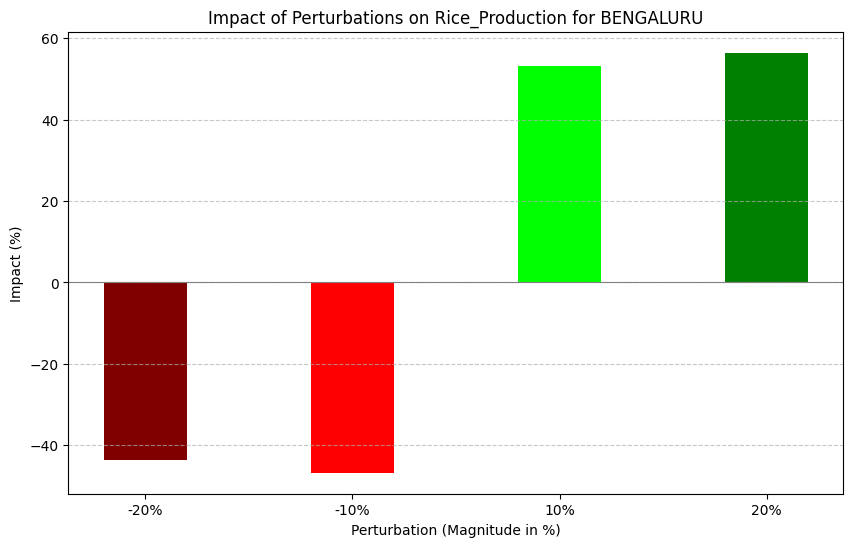

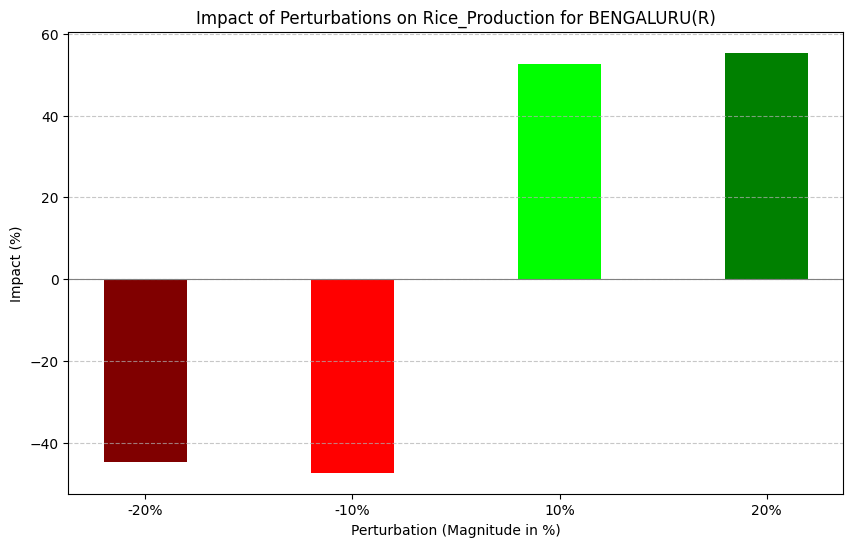

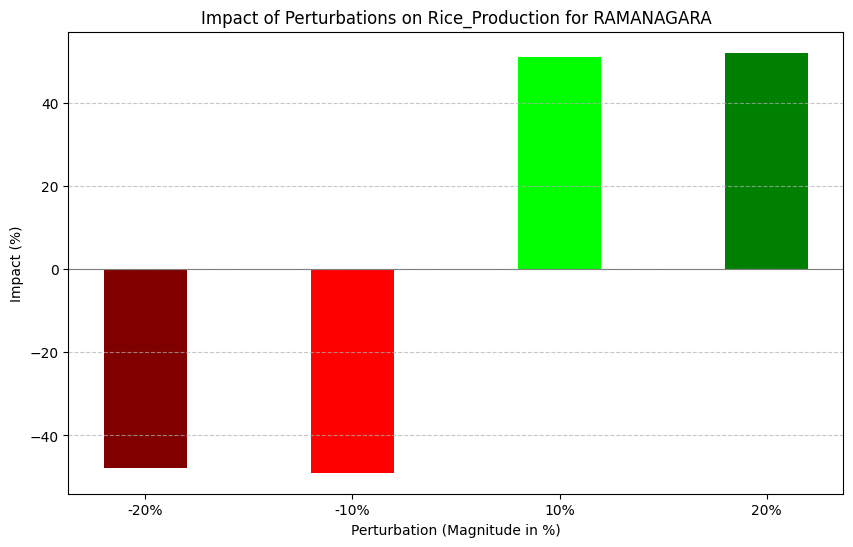

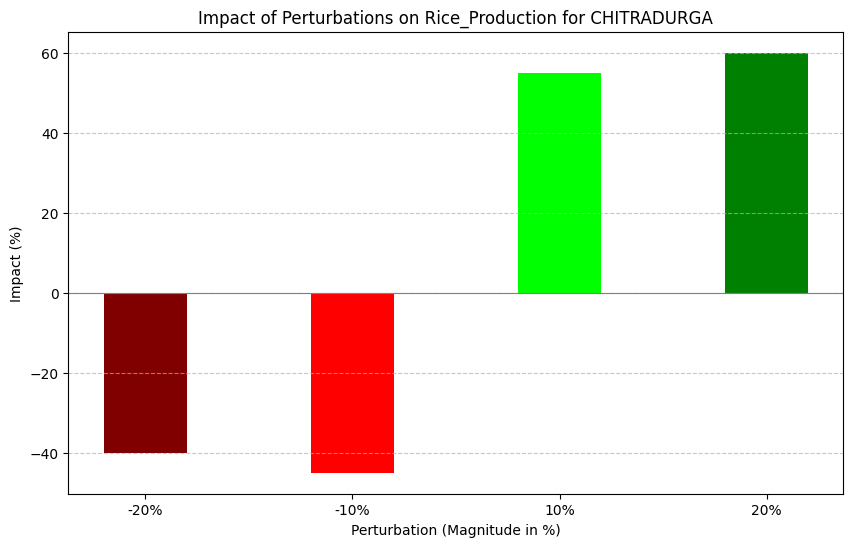

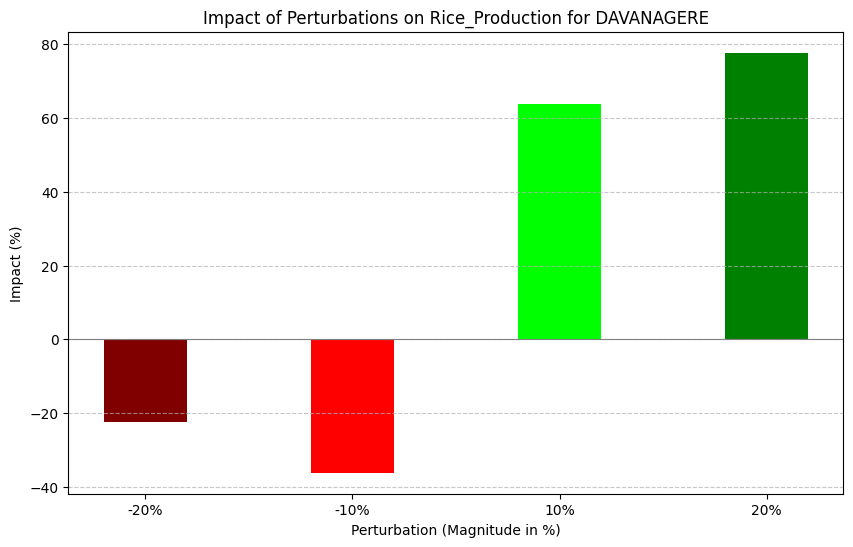

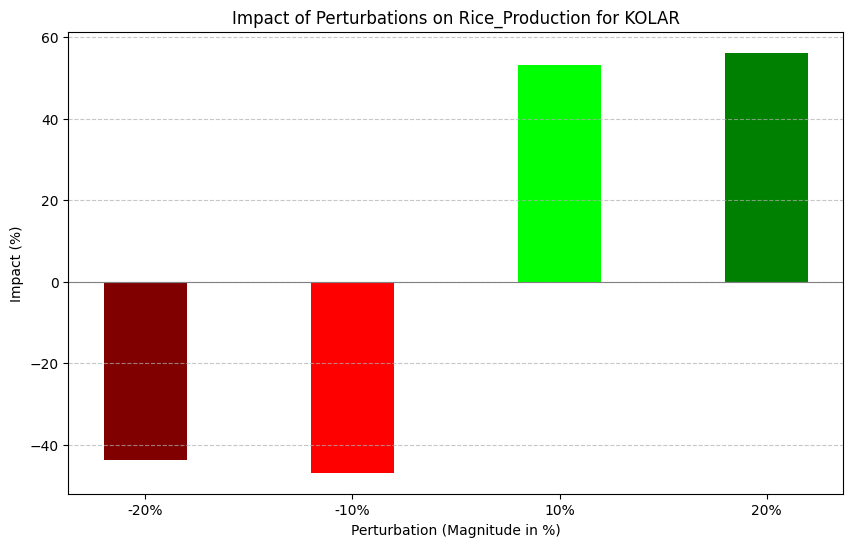

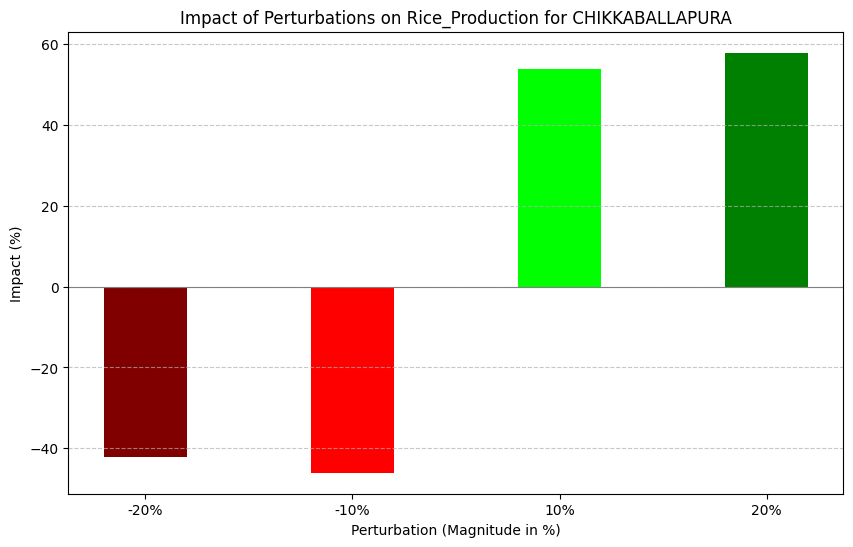

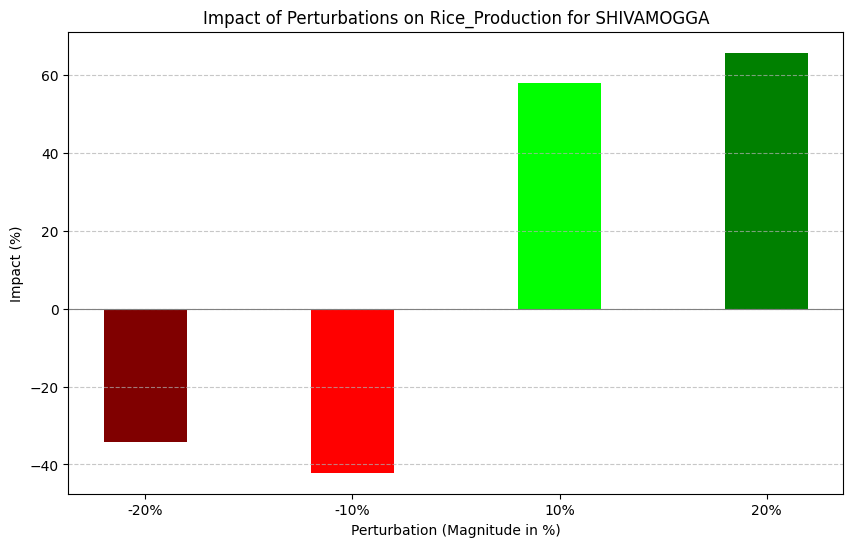

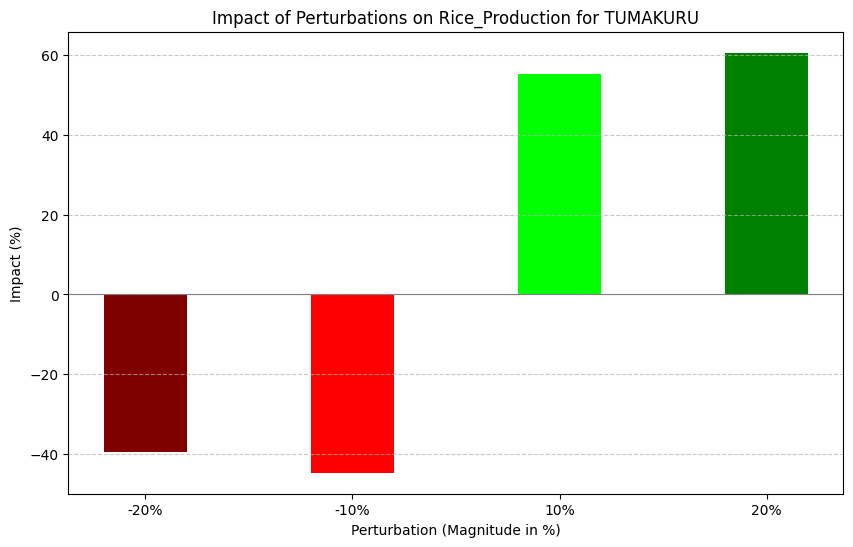

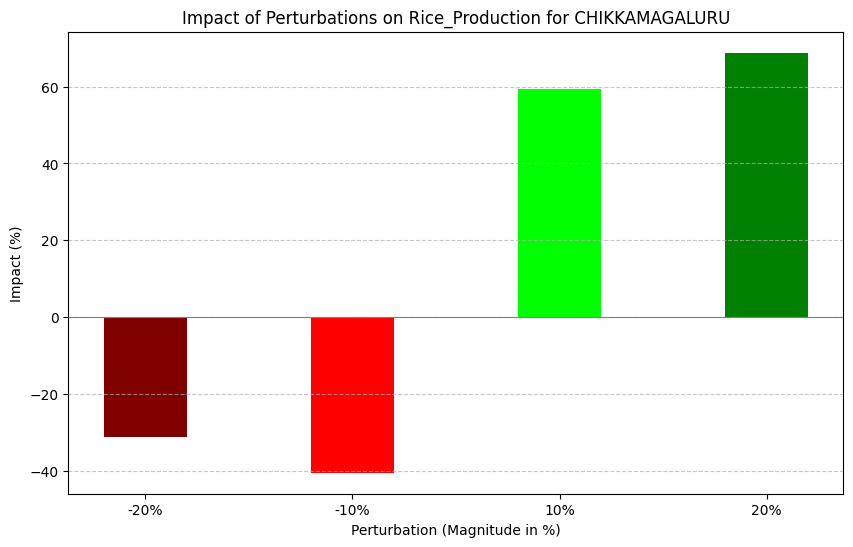

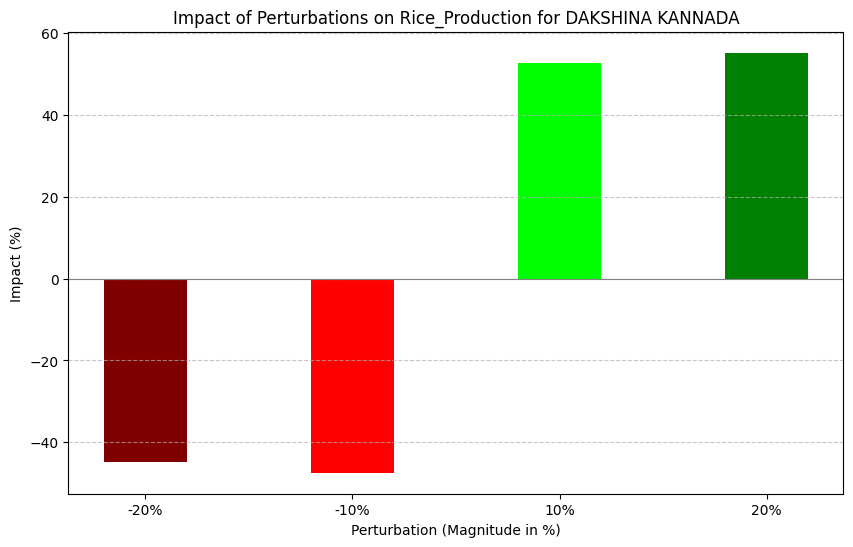

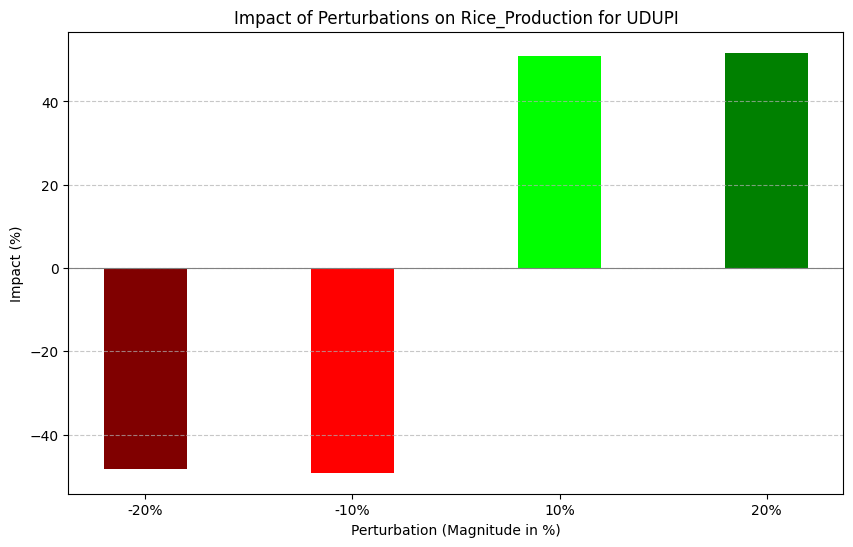

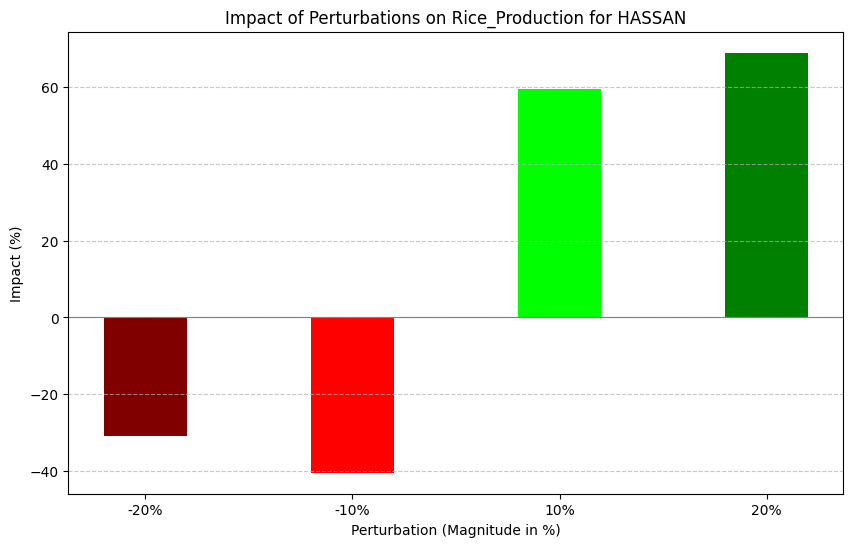

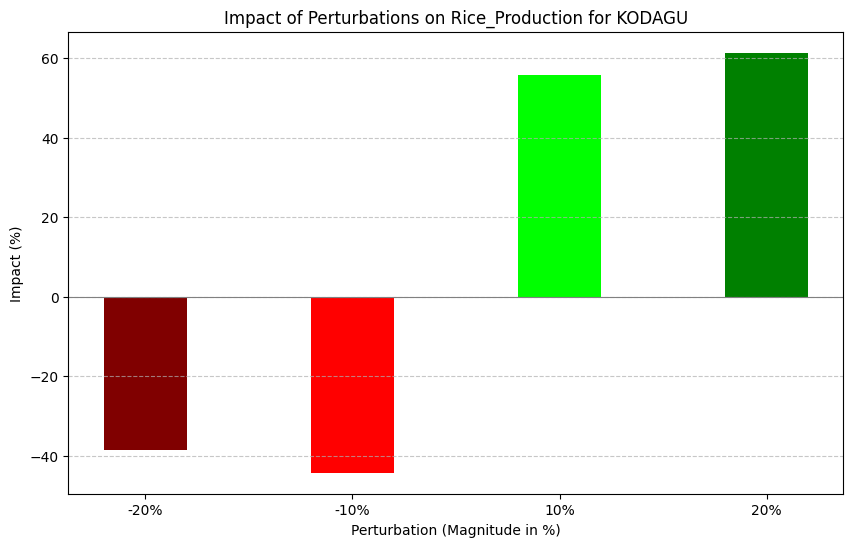

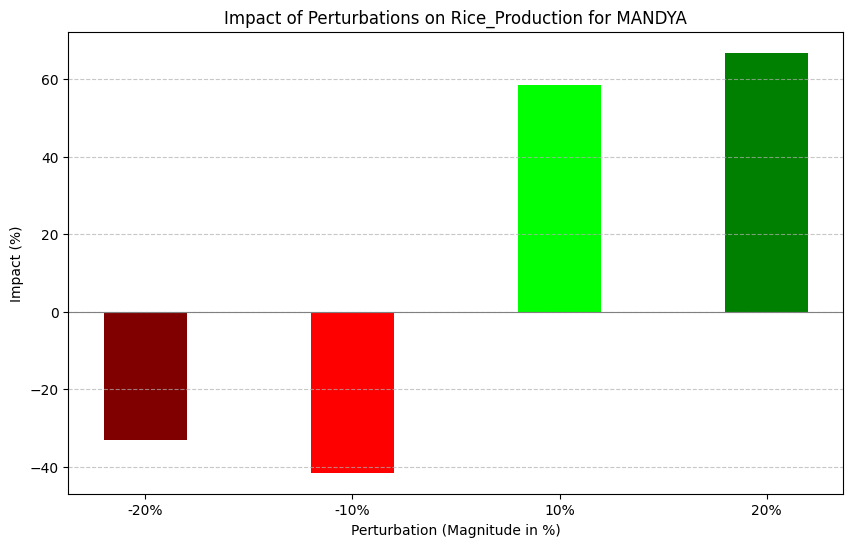

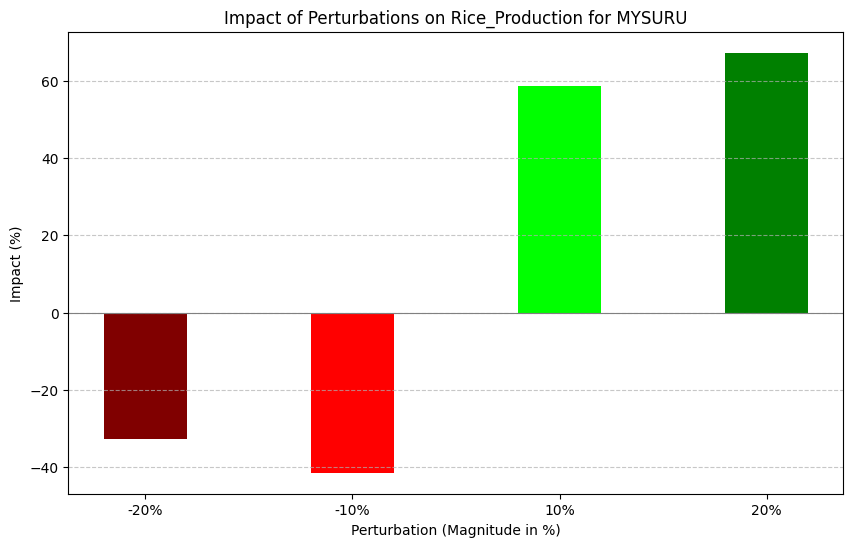

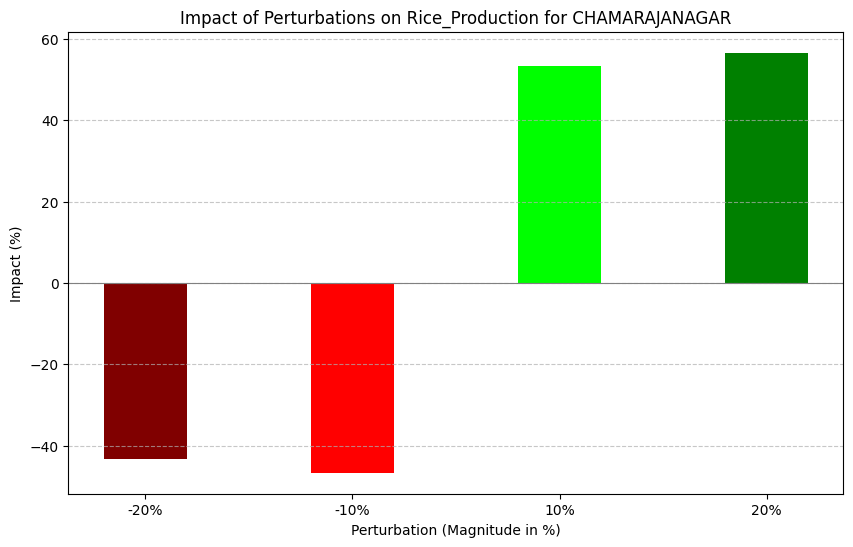

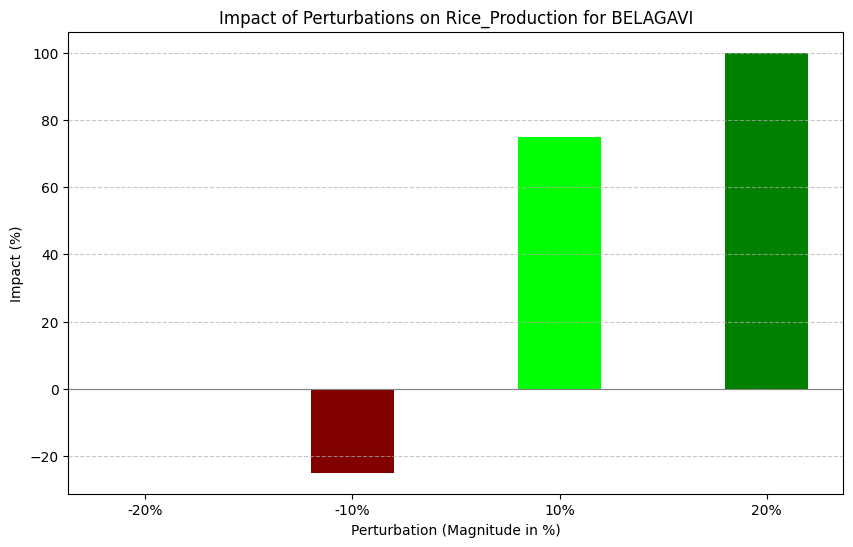

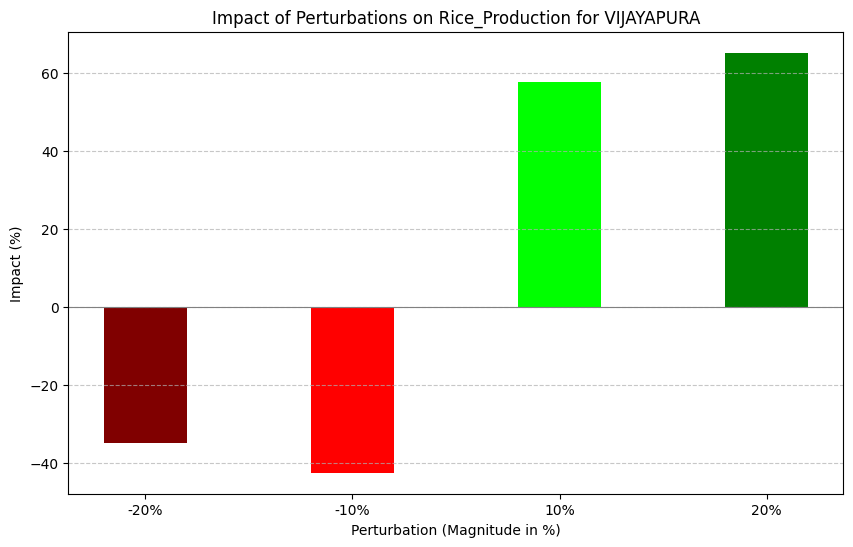

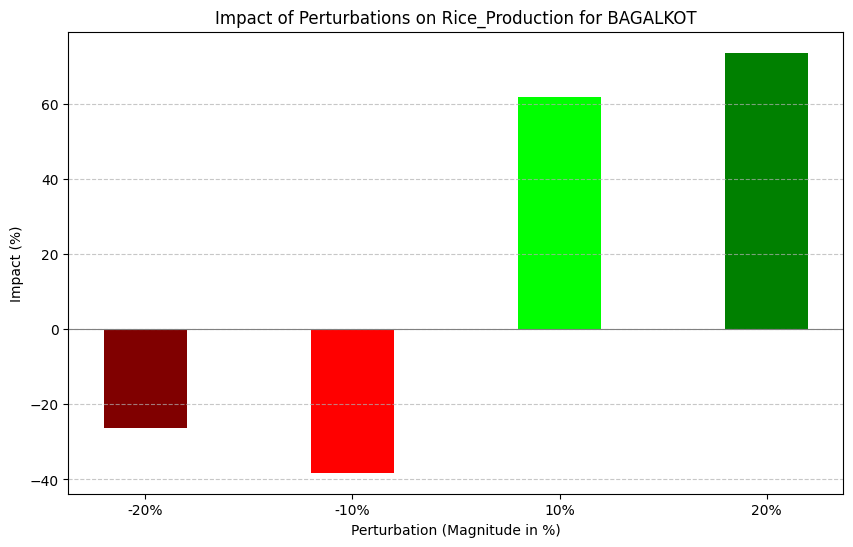

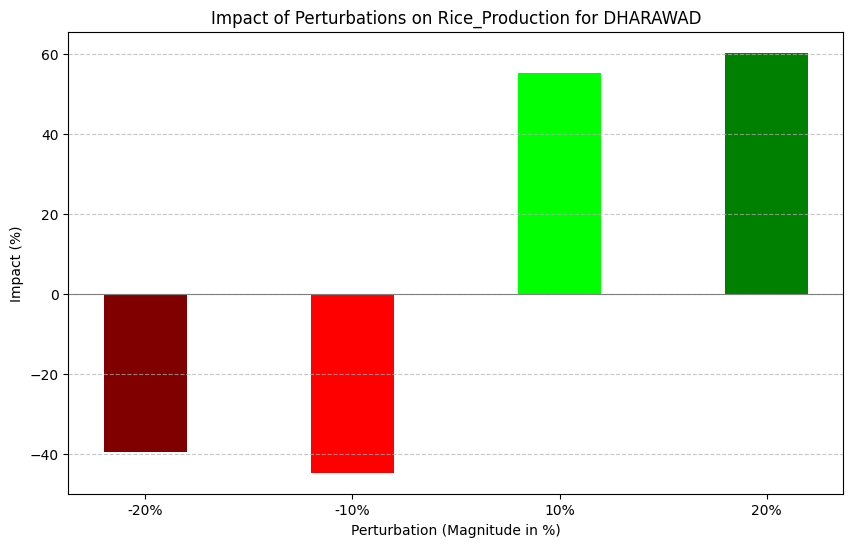

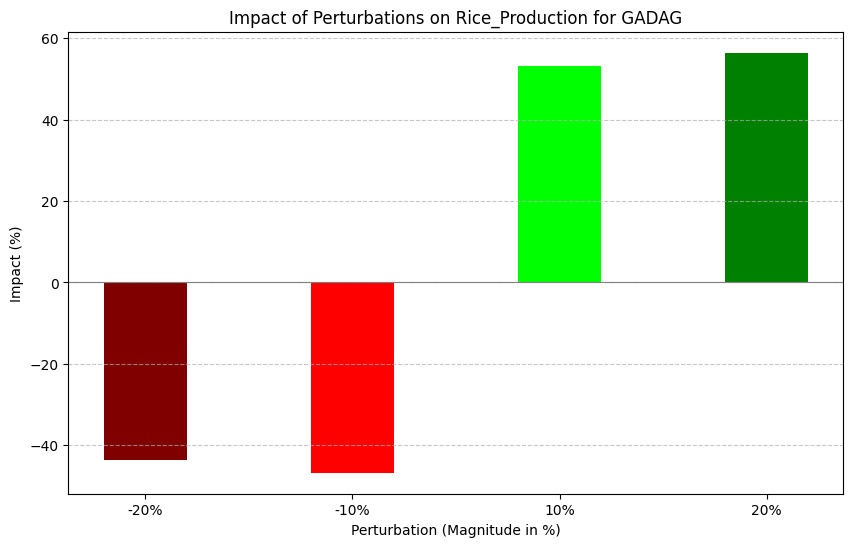

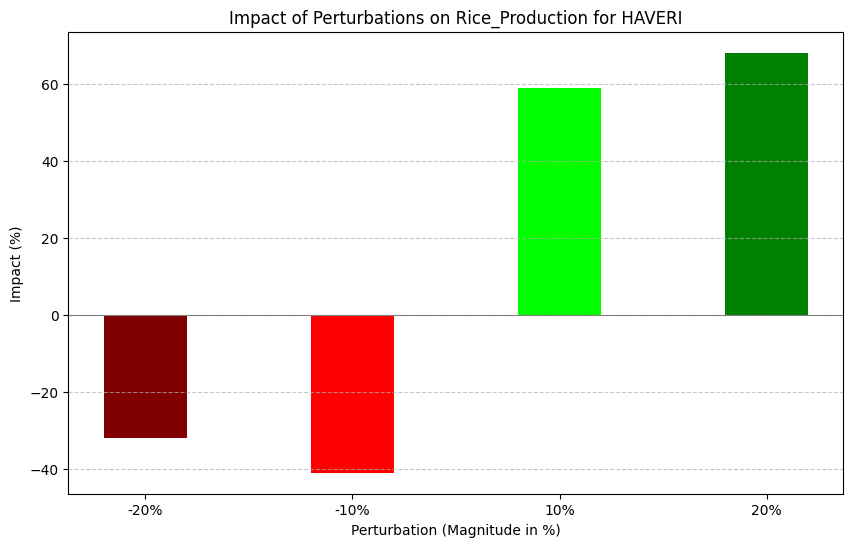

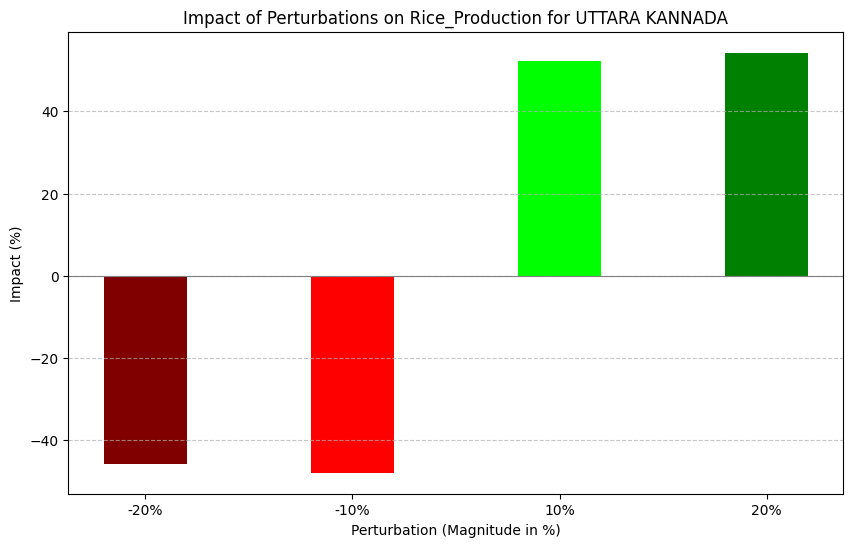

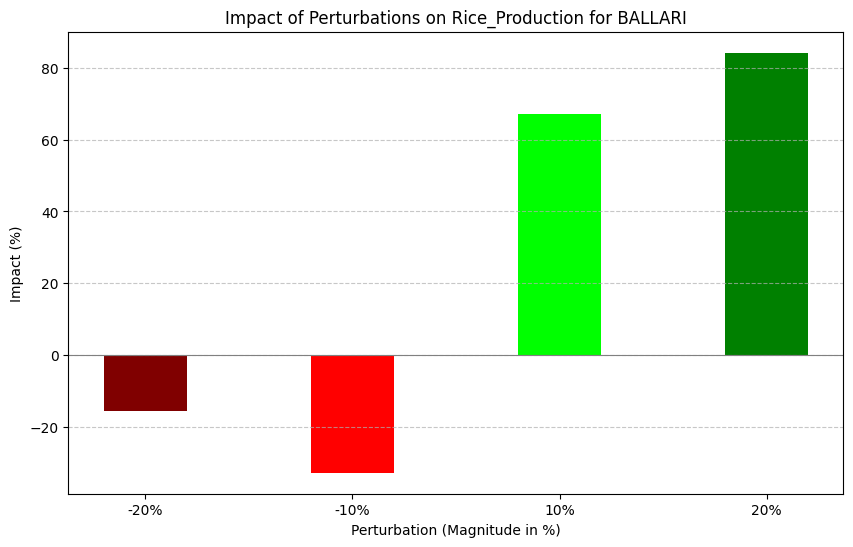

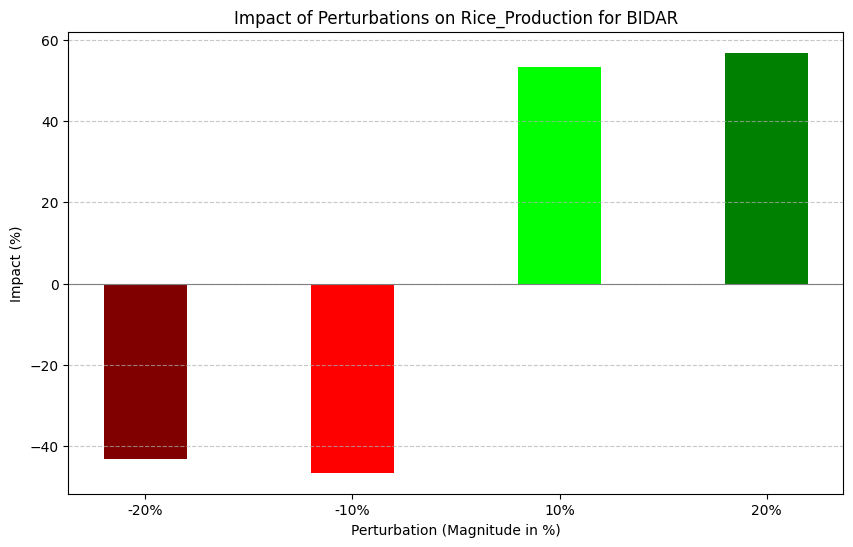

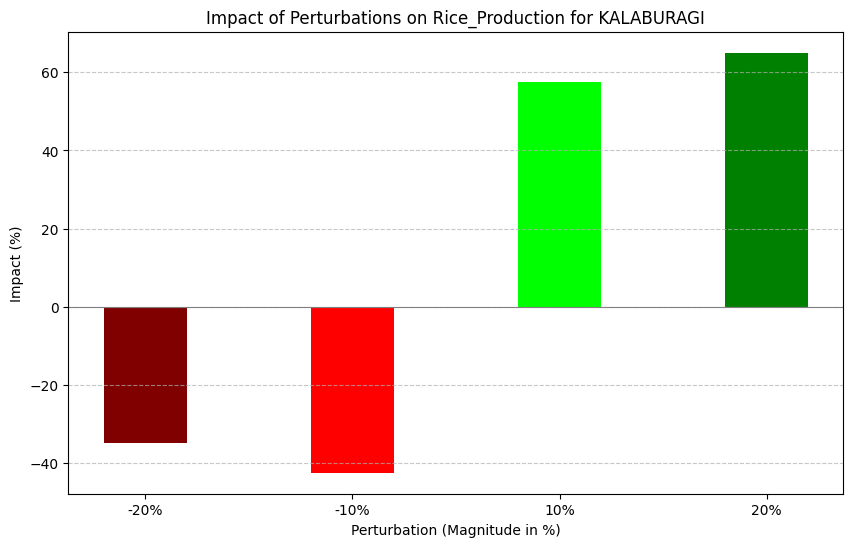

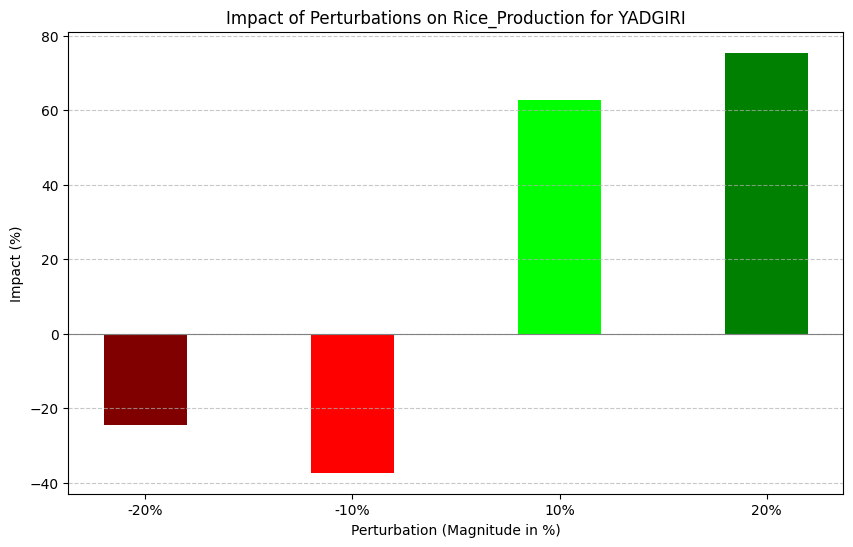

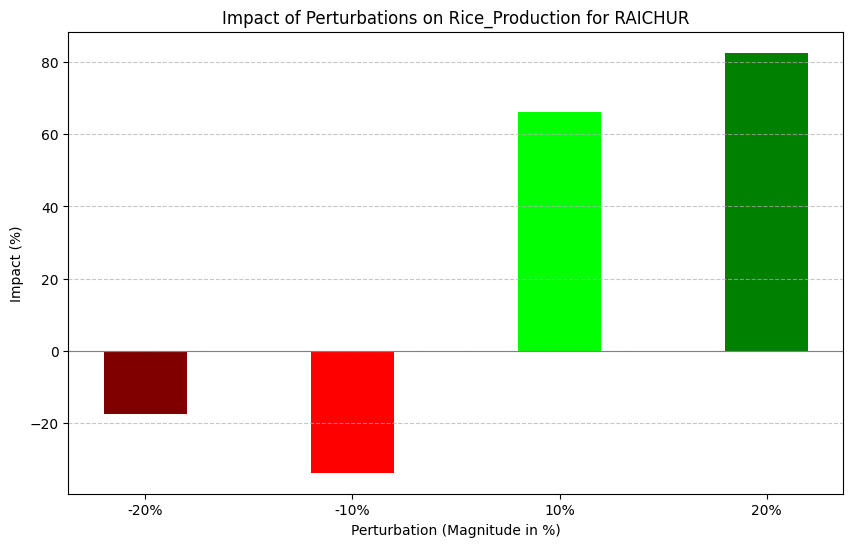

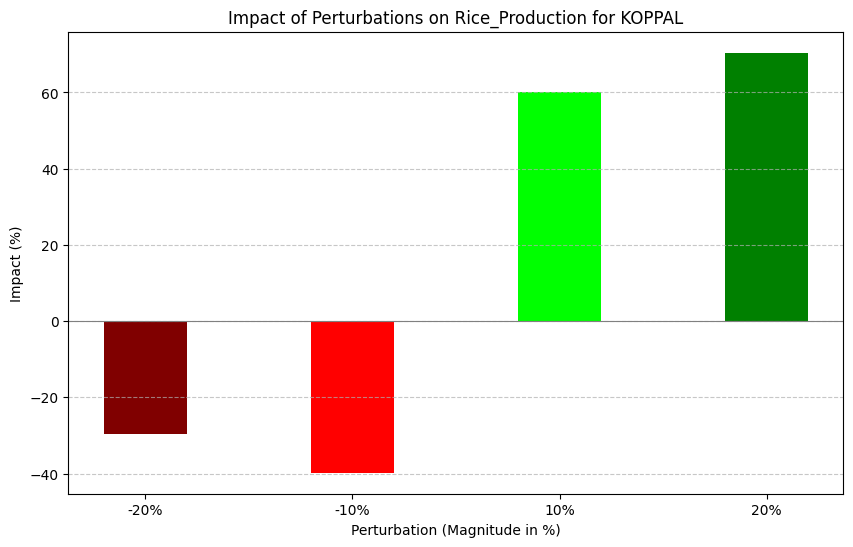

In [ ]:
import numpy as np  # Make sure to import numpy for handling arrays
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm


def perform_analysis(file_path, factor, Capability_Vector, perturbations):
    """
    Perform analysis on the impact of perturbations on a given factor for all districts.

    Parameters:
    - file_path: str, path to the dataset.
    - factor: str, the name of the factor column.
    - Capability_Vector: str, the name of the capability vector column.
    - perturbations: list, a list of perturbation percentages.
    """

    # Load the dataset
    data = pd.read_csv(file_path)

    # Selecting the specified factor and capability vector
    X = data[[factor]]
    y = data[Capability_Vector]

    # Performing linear regression using statsmodels
    X_with_const = sm.add_constant(X)  # Adding a constant for intercept
    model = sm.OLS(y, X_with_const).fit()
    m = model.params[factor]  # Slope
    c = model.params['const']  # Intercept

    results = []
    for district_name in data['District'].unique():
        # Filtering the data for the specific district
        district_data = data[data['District'] == district_name]

        for p in perturbations:
            perturbation_ratio = p / 100.0
            perturbed_factor_value = district_data[factor] * (1 + perturbation_ratio)  # Extract a single value

            # Calculating new cv using the perturbed factor value
            cv_new = m * perturbed_factor_value + c
            cv_old = m * district_data[factor] + c  # Extract a single value
            change_in_cv = cv_new - cv_old

            results.append({
                'District': district_name,
                'Perturbation (%)': p,
                f'{Capability_Vector} (old)': cv_old.values[0],  # Extract the single value
                f'{Capability_Vector} (new)': cv_new.values[0],  # Extract the single value
                f'Change in {Capability_Vector}': change_in_cv.values[0]  # Extract the single value
            })

    results_df = pd.DataFrame(results)

    # Initializing MinMaxScaler
    scaler = MinMaxScaler()
    # Scaling the 'Change in {Capability_Vector}' column
    normalized_change_in_cv_column = f' Impact (Normalized Change in {Capability_Vector}) '
    results_df[normalized_change_in_cv_column] = scaler.fit_transform(results_df[[f'Change in {Capability_Vector}']])

    # Modify the 'Impact (Normalized Change in Rice_Production)' column based on negative changes
    results_df.loc[results_df['Change in Rice_Production'] < 0, ' Impact (Normalized Change in Rice_Production) '] *= -1

    return results_df

def generate_colors(impacts):
    positive_impacts = [imp for imp in impacts if imp > 0]
    negative_impacts = [imp for imp in impacts if imp < 0]
    green_gradients = np.linspace(1, 0.5, len(positive_impacts)) if positive_impacts else []
    red_gradients = np.linspace(0.5, 1, len(negative_impacts)) if negative_impacts else []
    colors = []
    for impact in impacts:
        if impact > 0:
            index = positive_impacts.index(impact)
            color = (0, green_gradients[index], 0)
        elif impact < 0:
            index = negative_impacts.index(impact)
            color = (red_gradients[index], 0, 0)
        else:
            color = (0.8, 0.8, 0.8)
        colors.append(color)
    return colors




def plot_impact_analysis(results_df, capability_vector):
    for district_name in results_df['District'].unique():
        district_table = results_df[results_df['District'] == district_name].reset_index(drop=True)
        # Convert impact values from fractions to percentages
        impacts_in_percentage = district_table[f' Impact (Normalized Change in {capability_vector}) '] * 100
        colors = generate_colors(impacts_in_percentage)  # Ensure colors are generated based on updated impact values

        plt.figure(figsize=(10, 6))
        # Correct the perturbation display and adjust bar plotting
        plt.bar(district_table['Perturbation (%)'].astype(str) + '%', impacts_in_percentage, color=colors, width=0.4)
        plt.xlabel('Perturbation (Magnitude in %)')
        plt.ylabel('Impact (%)')  # Update y-label to indicate percentage
        plt.title(f'Impact of Perturbations on {capability_vector} for {district_name}')
        plt.axhline(0, color='gray', linewidth=0.8)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()


# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Please replace with your actual file path
factor = 'TotalNPK'
capability_vector = 'Rice_Production'
perturbations = [-20, -10, 10, 20]

results_df = perform_analysis(file_path, factor, capability_vector, perturbations)
plot_impact_analysis(results_df, capability_vector)


In [ ]:
##############(4.)SCATTER PLOT ANALYSIS

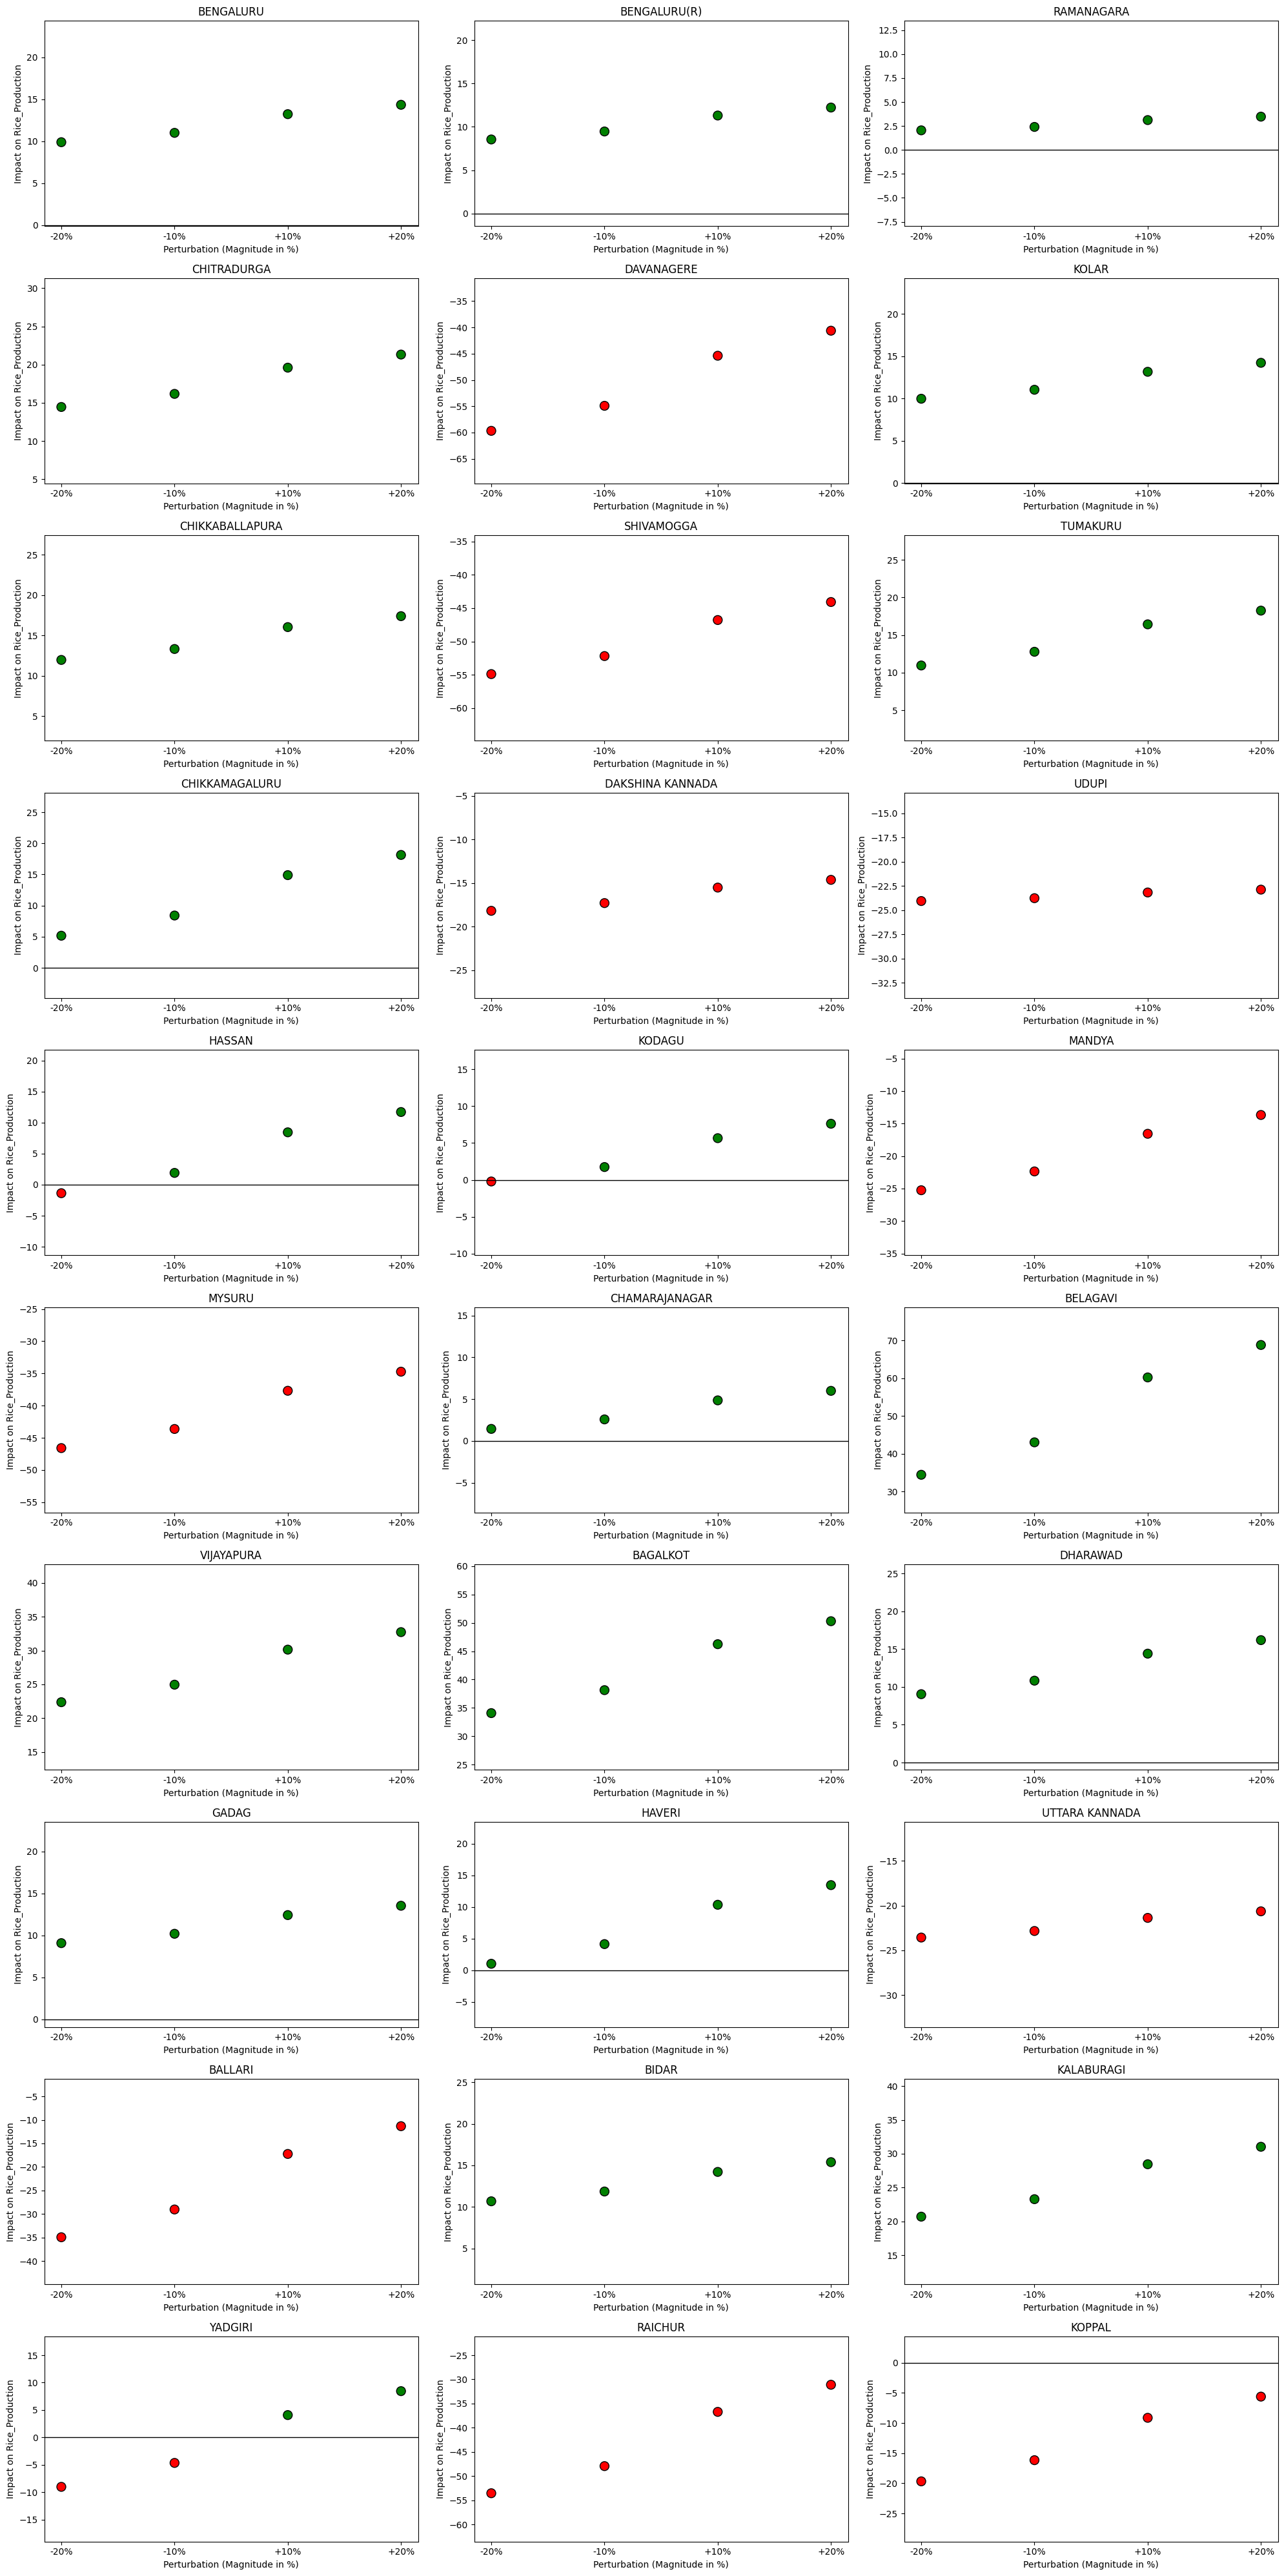

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

def generate_colors(impacts):
    return ['green' if impact > 0 else 'red' for impact in impacts]

def plot_impact_analysis_all_in_one(file_path, factor, Capability_Vector, user_perturbations):
    """
    Perform analysis on the impact of perturbations on a given factor and plot the results
    for all districts in a single figure using scatter plots.

    Parameters:
    - file_path: str, path to the dataset.
    - factor: str, the name of the factor column.
    - Capability_Vector: str, the name of the capability vector column.
    - user_perturbations: list, a list of perturbation percentages.
    """

    data = pd.read_csv(file_path)

    # Linear regression
    X = data[[factor]]
    y = data[Capability_Vector]
    model = LinearRegression()
    model.fit(X, y)

    perturbations_corrected = [p / 100.0 for p in user_perturbations]
    cv_min, cv_max = y.min(), y.max()

    # Prepare a figure to plot multiple subplots
    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed for clarity and space

    for i, district in enumerate(data['District'].unique(), start=1):
        district_factor = data.loc[data['District'] == district, factor].iloc[0]
        cv_old = data.loc[data['District'] == district, Capability_Vector].iloc[0]
        normalized_old = (cv_old - cv_min) / (cv_max - cv_min)

        impacts = []
        for p in perturbations_corrected:
            perturbed_factor = district_factor * (1 + p)
            cv_new = model.coef_[0] * perturbed_factor + model.intercept_
            normalized_new = (cv_new - cv_min) / (cv_max - cv_min)
            impact = (normalized_new - normalized_old) * 100
            impacts.append(impact)

        colors = generate_colors(impacts)

        # Adjust the subplot to have 10 rows and 3 columns
        plt.subplot(10,3, i)  # This will create a 10x3 grid for the subplots
        scatter_positions = np.arange(len(perturbations_corrected))
        plt.scatter(scatter_positions, impacts, color=colors, edgecolor='black', s=100)
        plt.xticks(scatter_positions, [f'{p*100:+.0f}%' for p in perturbations_corrected])
        plt.axhline(0, color='black', lw=1)
        plt.title(f'{district}')
        plt.xlabel('Perturbation (Magnitude in %)')
        plt.ylabel(f'Impact on {Capability_Vector}')

        # Adjust limits and annotate impacts if needed
        plt.ylim(min(impacts) - 10, max(impacts) + 10)

    plt.tight_layout()
    plt.show()

# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Update this path as needed
factor = 'TotalNPK'  # Adjust as needed
Capability_Vector = 'Rice_Production'  # Adjust as needed
user_perturbations = [-20, -10, 10, 20]  # Example perturbations in percentages

# Perform the analysis and plot for all districts in a single figure
plot_impact_analysis_all_in_one(file_path, factor, Capability_Vector, user_perturbations)


In [ ]:
##################(5.)BAR GRAPH IN 10x3 ALL 30 DISTRICTS

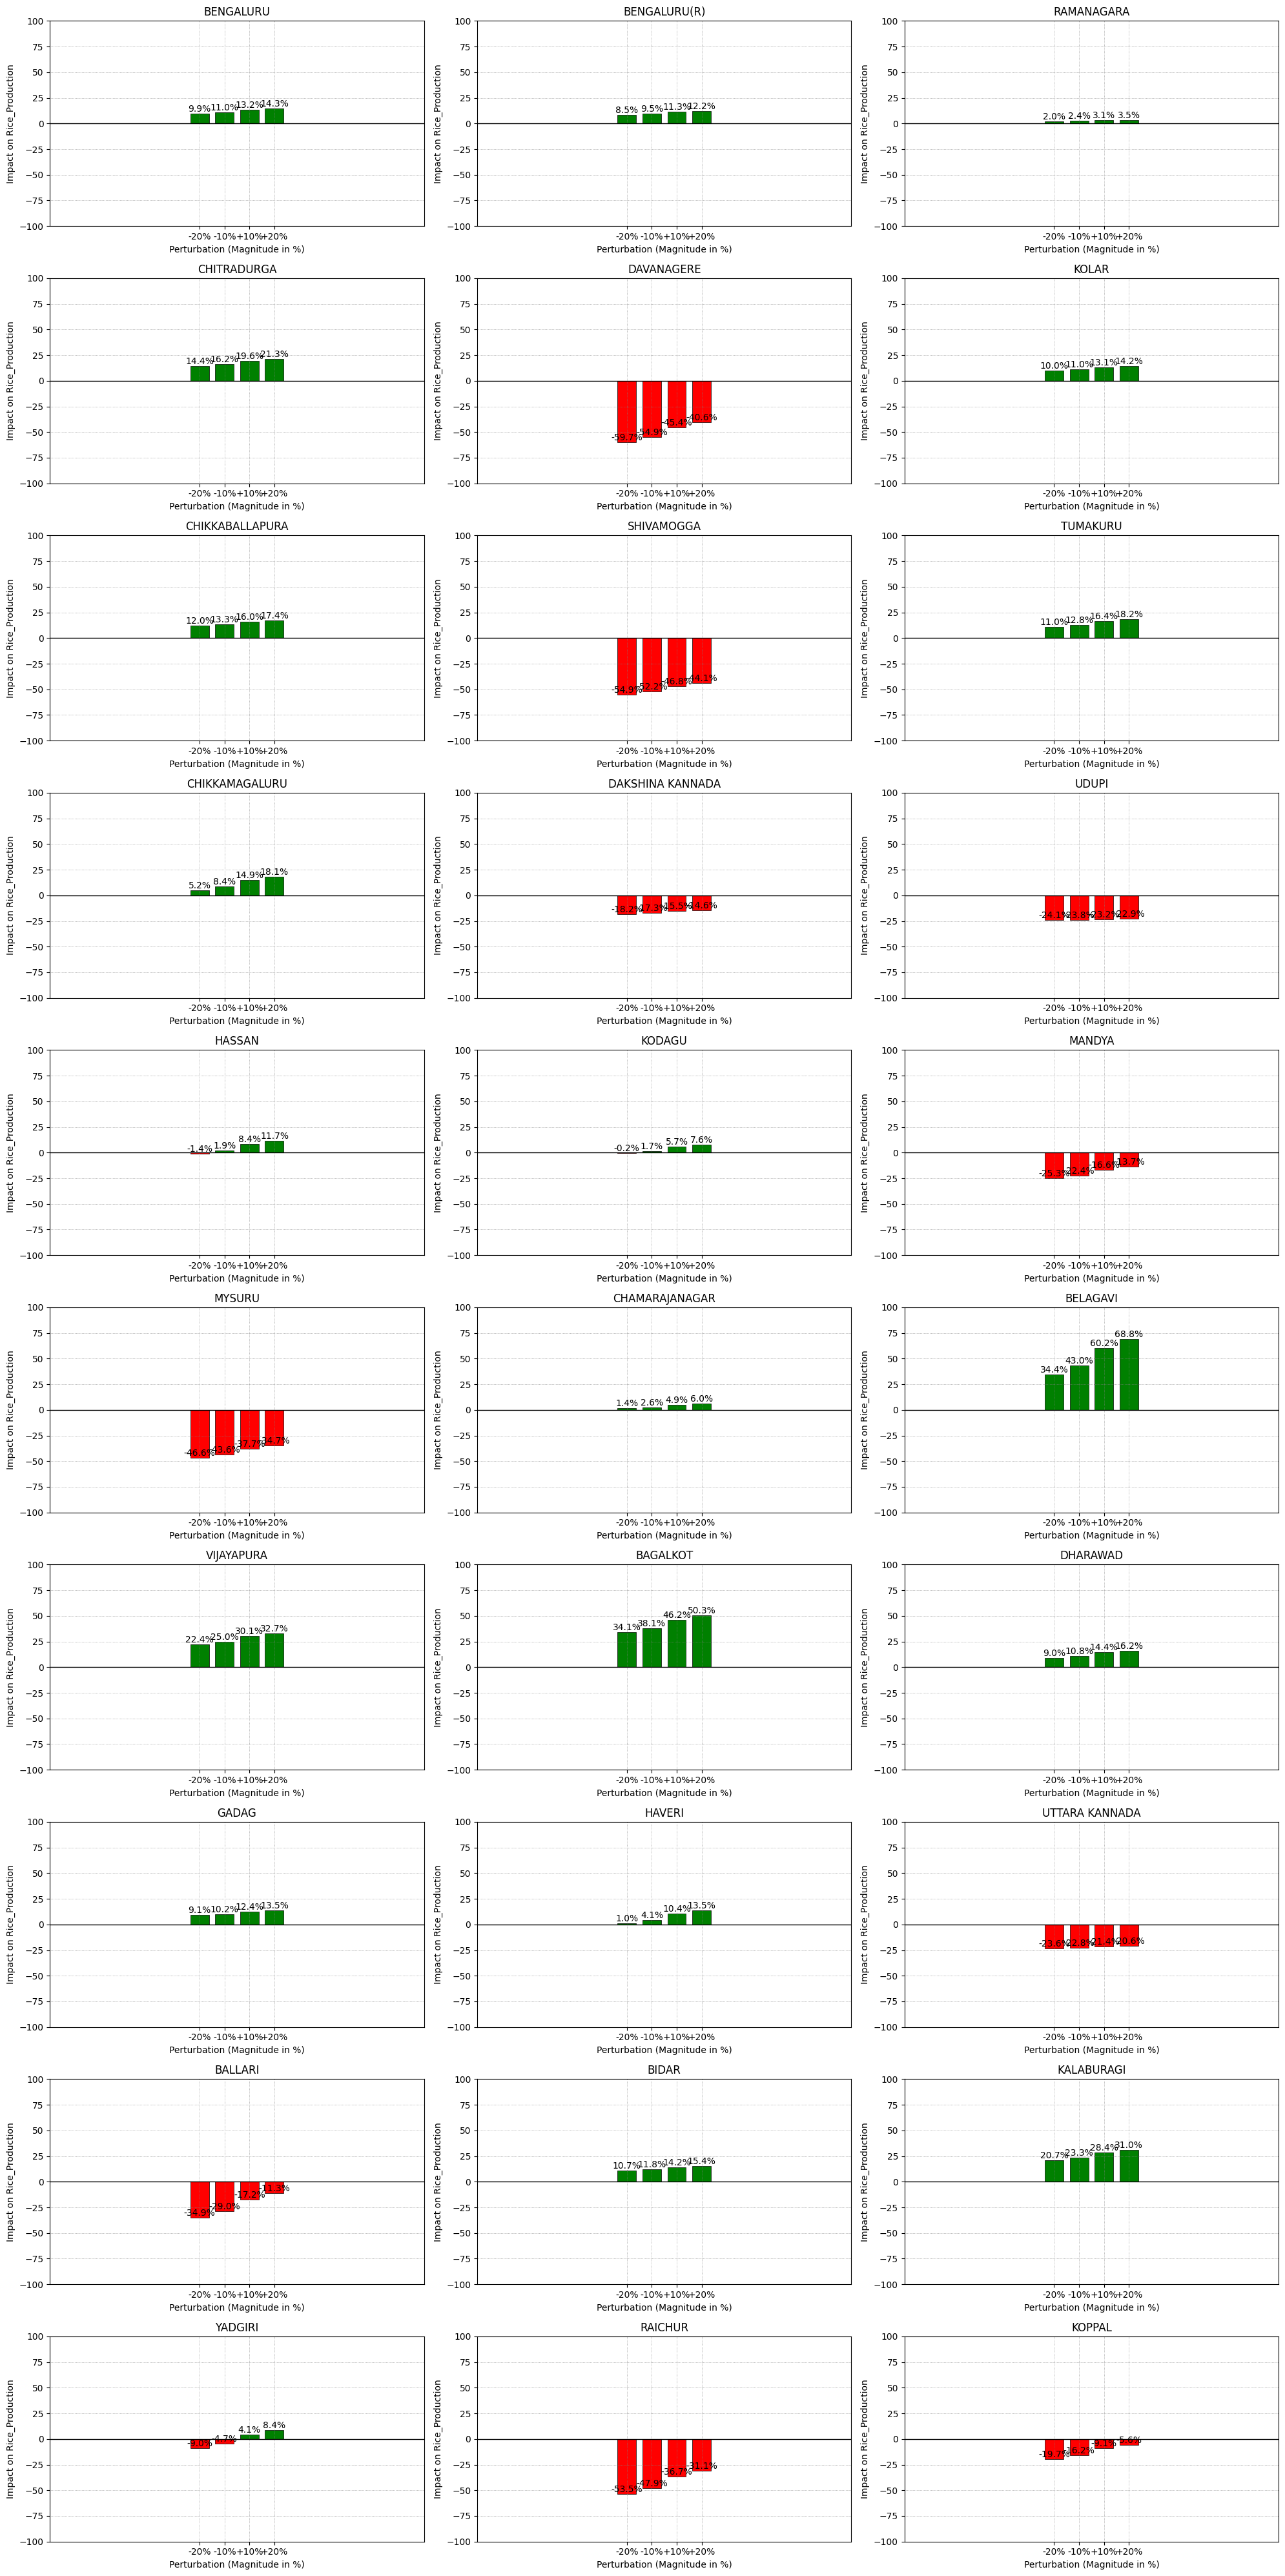

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

def generate_colors(impacts):
    return ['green' if impact > 0 else 'red' for impact in impacts]

def plot_impact_analysis_all_in_one(file_path, factor, Capability_Vector, user_perturbations):
    """
    Perform analysis on the impact of perturbations on a given factor and plot the results
    for all districts in a single figure using bar graphs.

    Parameters:
    - file_path: str, path to the dataset.
    - factor: str, the name of the factor column.
    - Capability_Vector: str, the name of the capability vector column.
    - user_perturbations: list, a list of perturbation percentages.
    """

    data = pd.read_csv(file_path)

    # Linear regression
    X = data[[factor]]
    y = data[Capability_Vector]
    model = LinearRegression()
    model.fit(X, y)

    perturbations_corrected = [p / 100.0 for p in user_perturbations]
    cv_min, cv_max = y.min(), y.max()

    # Prepare a figure to plot multiple subplots
    plt.figure(figsize=(20, 40))  # Adjust the figure size as needed for clarity and space

    for i, district in enumerate(data['District'].unique(), start=1):
        district_factor = data.loc[data['District'] == district, factor].iloc[0]
        cv_old = data.loc[data['District'] == district, Capability_Vector].iloc[0]
        normalized_old = (cv_old - cv_min) / (cv_max - cv_min)

        impacts = []
        for p in perturbations_corrected:
            perturbed_factor = district_factor * (1 + p)
            cv_new = model.coef_[0] * perturbed_factor + model.intercept_
            normalized_new = (cv_new - cv_min) / (cv_max - cv_min)
            impact = (normalized_new - normalized_old) * 100
            impacts.append(impact)

        colors = generate_colors(impacts)

        # Adjust the subplot to have 10 rows and 3 columns
        plt.subplot(10, 3, i)  # This will create a 10x3 grid for the subplots
        bar_positions = np.arange(len(perturbations_corrected)) * 4 - 6  # Adjust for desired gap between bars
        bars = plt.bar(bar_positions, impacts, color=colors, edgecolor='black', linewidth=0.5, width=3)
        plt.xticks(bar_positions, [f'{p*100:+.0f}%' for p in perturbations_corrected])
        plt.xlabel('Perturbation (Magnitude in %)')
        plt.ylabel(f'Impact on {Capability_Vector}')
        plt.title(f'{district}')
        plt.axhline(0, color='black', lw=1)

        # Adding gridlines
        plt.grid(True, linestyle=':', linewidth='0.5', color='gray')

        plt.xlim(-30, 30)
        plt.ylim(-100, 100)

        # Annotating the impact values with '%' suffix
        for bar, impact_value in zip(bars, impacts):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{impact_value:.1f}%',
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Update this path as needed
factor = 'TotalNPK'  # Adjust as needed
Capability_Vector = 'Rice_Production'  # Adjust as needed
user_perturbations = [-20, -10, 10, 20]  # Example perturbations in percentages

# Perform the analysis and plot for all districts in a single figure
plot_impact_analysis_all_in_one(file_path, factor, Capability_Vector, user_perturbations)


In [ ]:
###########(6.)WHICH PERTURBATION TO CHOOSE

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression

def choose_perturbation(data, Factor, Capability_Vector, user_perturbations):
    # Performing linear regression on the entire dataset
    X = data[[Factor]]
    y = data[Capability_Vector]
    model = LinearRegression()
    model.fit(X, y)
    m = model.coef_[0]  # Slope
    c = model.intercept_  # Intercept

    # Converting percentages to fractions for calculation
    perturbations_corrected = [p / 100.0 for p in user_perturbations]

    # Min-max normalization parameters for Capability_Vector
    cv_min = y.min()
    cv_max = y.max()

    # Initialize an empty list to store results for each district
    district_results = []

    # Loop through each unique district in the dataset
    for district in data['District'].unique():
        district_factor = data.loc[data['District'] == district, Factor].iloc[0]
        cv_old = data.loc[data['District'] == district, Capability_Vector].iloc[0]
        normalized_old = (cv_old - cv_min) / (cv_max - cv_min)
        positive_impacts = []
        negative_impacts = []
        for p in perturbations_corrected:
            perturbed_factor = district_factor * (1 + p)
            cv_new = m * perturbed_factor + c
            normalized_new = (cv_new - cv_min) / (cv_max - cv_min)
            impact = (normalized_new - normalized_old) * 100
            if impact > 0:
                positive_impacts.append((impact, p))
            elif impact < 0:
                negative_impacts.append((impact, p))
        # Choose perturbation based on conditions
        if positive_impacts and not negative_impacts:
            chosen_perturbation = max(positive_impacts)[1]
        elif not positive_impacts and negative_impacts:
            chosen_perturbation = max(negative_impacts)[1]
        elif positive_impacts and negative_impacts:
            chosen_perturbation = max(positive_impacts)[1]
        district_results.append({
            'District': district,
            'Perturbation_Choosen': f'P{user_perturbations.index(chosen_perturbation*100)+1}'
        })
    # Convert the results into a DataFrame and return
    return pd.DataFrame(district_results)

# Load the dataset
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Adjust this path as needed
data = pd.read_csv(file_path)

# User provided perturbations in percentages
user_perturbations = [-20, -10, 10, 20]

# Example usage
Factor = 'TotalNPK'
Capability_Vector = 'Rice_Production'
results_df = choose_perturbation(data, Factor, Capability_Vector, user_perturbations)
print(results_df)


            District Perturbation_Choosen
0          BENGALURU                   P4
1       BENGALURU(R)                   P4
2         RAMANAGARA                   P4
3        CHITRADURGA                   P4
4         DAVANAGERE                   P4
5              KOLAR                   P4
6    CHIKKABALLAPURA                   P4
7         SHIVAMOGGA                   P4
8           TUMAKURU                   P4
9     CHIKKAMAGALURU                   P4
10  DAKSHINA KANNADA                   P4
11             UDUPI                   P4
12            HASSAN                   P4
13            KODAGU                   P4
14            MANDYA                   P4
15            MYSURU                   P4
16    CHAMARAJANAGAR                   P4
17          BELAGAVI                   P4
18        VIJAYAPURA                   P4
19          BAGALKOT                   P4
20          DHARAWAD                   P4
21             GADAG                   P4
22            HAVERI              

In [ ]:
#########(6.)HEATMAP ANALYSIS

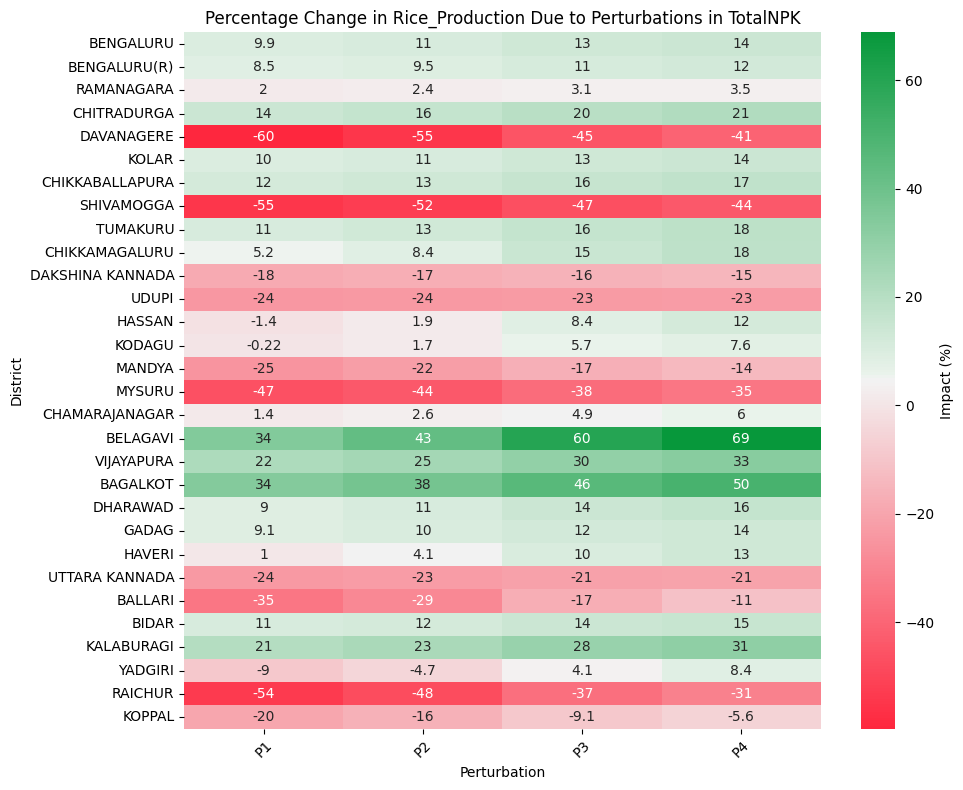

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

def impact_of_perturbations(file_path, factor, capability_vector, user_perturbations):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Performing linear regression on the specified factor against the capability vector
    X = data[[factor]]
    y = data[capability_vector]
    model = LinearRegression()
    model.fit(X, y)
    m = model.coef_[0]  # Slope of the regression
    c = model.intercept_  # Intercept of the regression

    # Convert user perturbations from percentages to multipliers
    perturbations_corrected = [p / 100.0 for p in user_perturbations]

    # Calculate the impact of each perturbation for each district
    impact_results = []
    for district in data['District'].unique():
        district_data = []
        district_factor_value = data.loc[data['District'] == district, factor].iloc[0]
        original_capability_value = data.loc[data['District'] == district, capability_vector].iloc[0]
        for perturbation in perturbations_corrected:
            perturbed_factor_value = district_factor_value * (1 + perturbation)
            predicted_capability_value = m * perturbed_factor_value + c
            normalized_new = (predicted_capability_value - y.min()) / (y.max() - y.min())
            normalized_old = (original_capability_value - y.min()) / (y.max() - y.min())
            impact = (normalized_new - normalized_old) * 100
            district_data.append(impact)
        impact_results.append(district_data)

    # Create a DataFrame for the heatmap
    impact_df = pd.DataFrame(impact_results, columns=[f'P{i+1}' for i in range(len(user_perturbations))], index=data['District'].unique())

    # Plotting the heatmap
    cmap = sns.diverging_palette(10, 133, s=99, l=55, sep=3, as_cmap=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(impact_df, cmap=cmap, annot=True, cbar_kws={'label': 'Impact (%)'})
    plt.title(f'Percentage Change in {capability_vector} Due to Perturbations in {factor}')
    plt.ylabel('District')
    plt.xlabel('Perturbation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example usage
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Adjust this path as needed
factor = 'TotalNPK'  # Factor to analyze
capability_vector = 'Rice_Production'  # Target capability vector
user_perturbations = [-20, -10, 10, 20]  # Perturbations in percentages

# Call the function
impact_of_perturbations(file_path, factor, capability_vector, user_perturbations)
